In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [2]:
import os

In [3]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

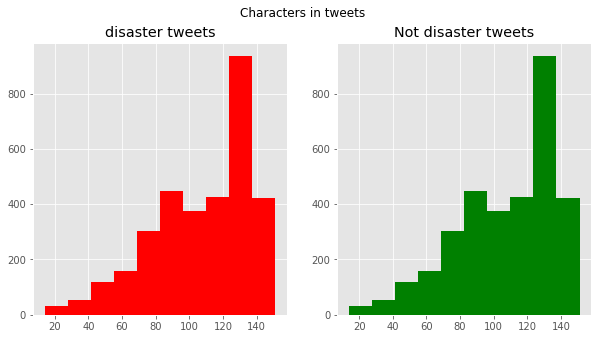

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

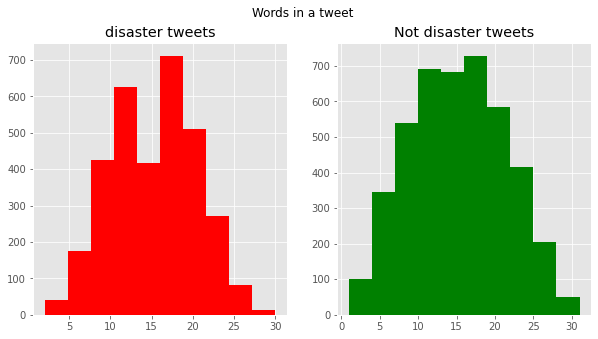

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

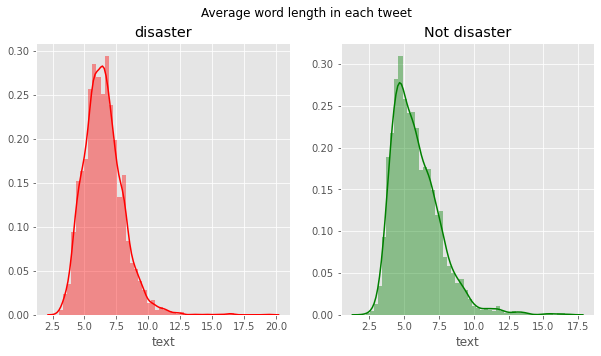

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [7]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [8]:
# Analyzing tweets of class 0
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

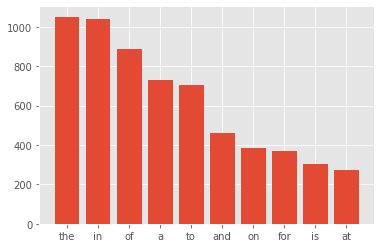

In [12]:
# Analyzing tweets of class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

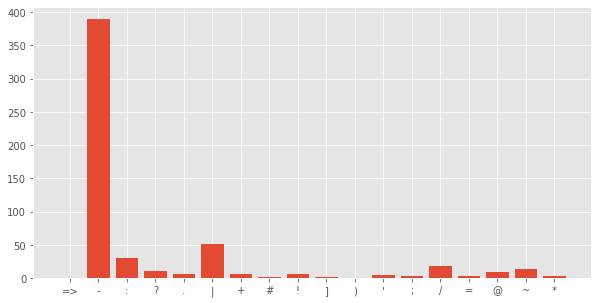

In [13]:
# Class 1
plt.figure(figsize =(10,5))
corpus = create_corpus(1)

dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
x,y = zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

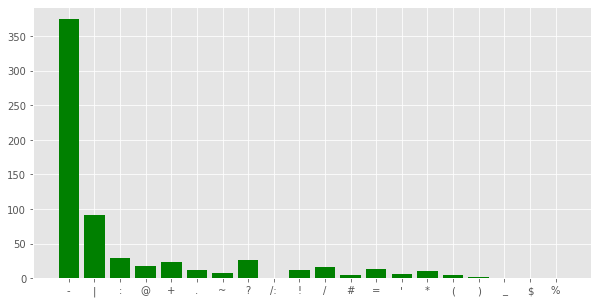

In [15]:
# Class 0
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [16]:
# Common words
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

<AxesSubplot:>

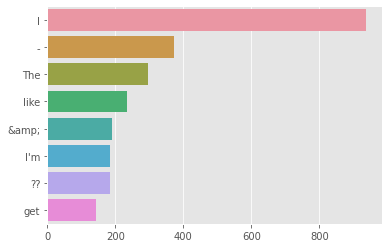

In [17]:
sns.barplot(x=y,y=x)

In [18]:
# NGram analysis
def get_top_tweet_bigrams(corpus,n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

<AxesSubplot:>

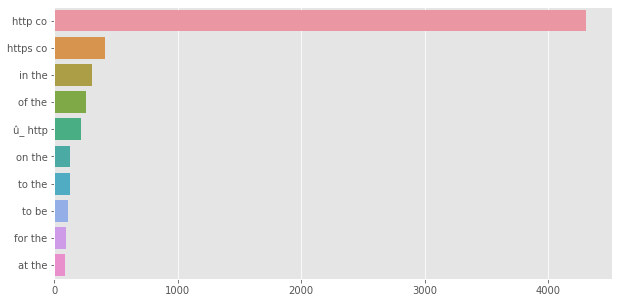

In [19]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [20]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [21]:
# Removing punctuations, urls, spelling correction and emojis.
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [22]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [23]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [24]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove_emoji("Omg another Earthquake 😔😔")

In [26]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [27]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [28]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [29]:
# Spelling correction
!pip install pyspellchecker

     |████████████████████████████████| 1.9 MB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Users/snehgurdasani/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [32]:
# Glove for Vectorization
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1)&(word not in stop))]
        corpus.append(words)
    return corpus

In [33]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 8041.92it/s]


In [34]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [35]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post',padding='post')

In [36]:
tweet_pad

array([[ 622, 5467,  738, ...,    0,    0,    0],
       [  96,    7,  138, ...,    0,    0,    0],
       [ 119, 1469, 1386, ...,    0,    0,    0],
       ...,
       [ 749,  478,  348, ...,    0,    0,    0],
       [4085,  536,  372, ...,    0,    0,    0],
       [3997, 2557, 1462, ...,    0,    0,    0]], dtype=int32)

In [37]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [38]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 20342/20342 [00:00<00:00, 197221.38it/s]


In [39]:
# LSTM Neural network model
model = Sequential()

embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                     input_length = MAX_LEN, trainable = False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64,dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation = 'sigmoid'))

optimizer = Adam(learning_rate = 1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [41]:
train = tweet_pad[:tweet.shape[0]]
test = tweet_pad[tweet.shape[0]:]

In [44]:
X_train,X_test,y_train,y_test = train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [45]:
history = model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test, y_test), verbose=2)

Epoch 1/15
1618/1618 - 58s - loss: 0.6906 - accuracy: 0.5684 - val_loss: 0.6769 - val_accuracy: 0.5771
Epoch 2/15
1618/1618 - 62s - loss: 0.5830 - accuracy: 0.7090 - val_loss: 0.5385 - val_accuracy: 0.7557
Epoch 3/15
1618/1618 - 64s - loss: 0.5418 - accuracy: 0.7509 - val_loss: 0.5220 - val_accuracy: 0.7627
Epoch 4/15
1618/1618 - 63s - loss: 0.5222 - accuracy: 0.7642 - val_loss: 0.5106 - val_accuracy: 0.7715
Epoch 5/15
1618/1618 - 61s - loss: 0.5153 - accuracy: 0.7616 - val_loss: 0.5032 - val_accuracy: 0.7741
Epoch 6/15
1618/1618 - 58s - loss: 0.5062 - accuracy: 0.7688 - val_loss: 0.4942 - val_accuracy: 0.7767
Epoch 7/15
1618/1618 - 59s - loss: 0.5007 - accuracy: 0.7728 - val_loss: 0.4880 - val_accuracy: 0.7820
Epoch 8/15
1618/1618 - 60s - loss: 0.4883 - accuracy: 0.7807 - val_loss: 0.4871 - val_accuracy: 0.7828
Epoch 9/15
1618/1618 - 61s - loss: 0.4883 - accuracy: 0.7796 - val_loss: 0.4811 - val_accuracy: 0.7881
Epoch 10/15
1618/1618 - 59s - loss: 0.4887 - accuracy: 0.7784 - val_loss:

In [46]:
# Sample submission
sample_sub=pd.read_csv('sample_submission.csv')

In [47]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [48]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [49]:
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
